# Usupervised classification of philosophical genres

This notebook is a part of work being done for the [Trace of Theory project](https://github.com/htrc/ACS-TT), a collaboration between researchers of [NovelTM](http://novel-tm.ca/) and the HathiTrust Research Center ([HTRC](https://www.hathitrust.org/)).

Here, we'll use unsupervised techniques to identify clusters of similar texts within a corpus of about 3,200 philosophical texts. The idea is to look for something like "genre" and to compare the computational results to human labels. Our features will mix word-count data with measures of form and with textual metadata, so that we're examining not just subject matter, but also style and (minimal) context.

## Imports

In [197]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from nltk.corpus.reader import PlaintextCorpusReader
from nltk.corpus import cmudict
import nltk
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import os
import subprocess
import bz2
#from htrc_features import FeatureReader
import json

# Set up plotting
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
basecolor = 'steelblue'
% matplotlib inline

## Get input files

We use the existing list of 3,231 philosophical texts, from which we just want basic metadata and HTIDs in order to download the corresponding [HTRC derived feature](https://sharc.hathitrust.org/features) files. Note that I'm using the 'clean' version of the list, which is UTF-8 encoded.

In [166]:
philo_list = pd.read_csv('../../data/philosophy/over1 freqsort test clean.csv')
philo_list = philo_list[['Discipline', 'ID', 'Title', 'Author', 'Year', 'Relative Freq']]
philo_list.columns = ['label', 'htid', 'title', 'auth', 'year', 'freq']
philo_list.head()

,label,htid,title,auth,year,freq
0,theo,uc2.ark:/13960/t4jm2cj7x,Will higher of God and free will of life made ...,"Comstock, William Charles, 1847-1924.",1914,0.262600
1,theo,uc2.ark:/13960/t6j105c55,"Man, the life free, by the authors of ""Thought...","Comstock, William Charles, 1847-1924.",1916,0.257248
2,theo,uc2.ark:/13960/t2f76gd3p,"Thought for help, from those who know men's ne...","Comstock, William Charles, 1847-1924.",1913,0.218047
3,ed,loc.ark:/13960/t97664b0x,The metaphysics of education. [By] Arthur C Fl...,"Fleshman, Arthur Cary.",1914,0.174253
4,ed,uc2.ark:/13960/t18k7739n,Syllabus of a course on the philosophy of educ...,"MacVannel, John Angus, 1871-1915.",1904,0.169895


In the data, 'freq' is the relative frequency of philosophical keywords. We may or may not end up using this. The field for 'disc' is a human-applied label for the type of philosophy in each volume. The labels are distributed like so:

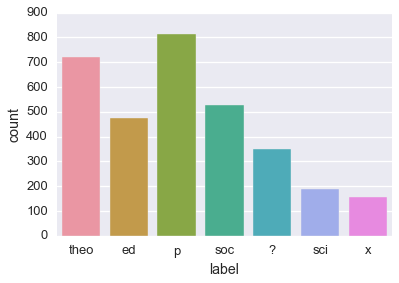

In [167]:
sns.countplot(x='label', data=philo_list)

OK, so really only about 25% of the 'philosophical' texts are labeled philosophy proper. We'll bear this in mind. Noew we want to download the HTRC derived feature files for those 3,231 volumes. To do that, we'll generate a list of them, then use rsync to bring them over to local storage.

In [168]:
# Convert HTIDs to filesystem-safe versions for rsync
philo_list['file'] = philo_list['htid'].str.replace(':', '+')
philo_list['file'] = philo_list['file'].str.replace('/', '=')
philo_list = philo_list[['label', 'title', 'auth', 'year', 'freq', 'htid', 'file']]
philo_list.head()

,label,title,auth,year,freq,htid,file
0,theo,Will higher of God and free will of life made ...,"Comstock, William Charles, 1847-1924.",1914,0.262600,uc2.ark:/13960/t4jm2cj7x,uc2.ark+=13960=t4jm2cj7x
1,theo,"Man, the life free, by the authors of ""Thought...","Comstock, William Charles, 1847-1924.",1916,0.257248,uc2.ark:/13960/t6j105c55,uc2.ark+=13960=t6j105c55
2,theo,"Thought for help, from those who know men's ne...","Comstock, William Charles, 1847-1924.",1913,0.218047,uc2.ark:/13960/t2f76gd3p,uc2.ark+=13960=t2f76gd3p
3,ed,The metaphysics of education. [By] Arthur C Fl...,"Fleshman, Arthur Cary.",1914,0.174253,loc.ark:/13960/t97664b0x,loc.ark+=13960=t97664b0x
4,ed,Syllabus of a course on the philosophy of educ...,"MacVannel, John Angus, 1871-1915.",1904,0.169895,uc2.ark:/13960/t18k7739n,uc2.ark+=13960=t18k7739n


In [169]:
# A function to convert HTIDs to pairtree paths
def htid2ptpath(htid, prefix='basic', suffix='.basic.json.bz2'):
    '''A function to convert HathiTrust file IDs to pairtree paths.
        Takes an input HTID, an optional path prefix to be prepended the
        generated path, an optional suffix (like '.basic.json.bz2'), and 
        an optional path separator (default: '/').
        Returns a string representing the HTRC pairtree path.'''
    inst, ptid = htid.split(sep='.', maxsplit=1)
    pt_segments = (len(ptid)//2) + 1
    path = prefix + '/' + inst + '/' + 'pairtree_root' + '/'
    for i in range(pt_segments):
        try:
            path += ptid[i*2:(i+1)*2] + '/'
        except:
            path += ptid[i*2:i*2+1] + '/'
    return path[0:-1] + ptid + '/' + inst + '.' + ptid + suffix

In [170]:
philo_list['path'] = philo_list['file'].apply(htid2ptpath)
philo_list.head()

,label,title,auth,year,freq,htid,file,path
0,theo,Will higher of God and free will of life made ...,"Comstock, William Charles, 1847-1924.",1914,0.262600,uc2.ark:/13960/t4jm2cj7x,uc2.ark+=13960=t4jm2cj7x,basic/uc2/pairtree_root/ar/k+/=1/39/60/=t/4j/m...
1,theo,"Man, the life free, by the authors of ""Thought...","Comstock, William Charles, 1847-1924.",1916,0.257248,uc2.ark:/13960/t6j105c55,uc2.ark+=13960=t6j105c55,basic/uc2/pairtree_root/ar/k+/=1/39/60/=t/6j/1...
2,theo,"Thought for help, from those who know men's ne...","Comstock, William Charles, 1847-1924.",1913,0.218047,uc2.ark:/13960/t2f76gd3p,uc2.ark+=13960=t2f76gd3p,basic/uc2/pairtree_root/ar/k+/=1/39/60/=t/2f/7...
3,ed,The metaphysics of education. [By] Arthur C Fl...,"Fleshman, Arthur Cary.",1914,0.174253,loc.ark:/13960/t97664b0x,loc.ark+=13960=t97664b0x,basic/loc/pairtree_root/ar/k+/=1/39/60/=t/97/6...
4,ed,Syllabus of a course on the philosophy of educ...,"MacVannel, John Angus, 1871-1915.",1904,0.169895,uc2.ark:/13960/t18k7739n,uc2.ark+=13960=t18k7739n,basic/uc2/pairtree_root/ar/k+/=1/39/60/=t/18/k...


In [171]:
# Write out list of feature files for use by rsync
philo_list['path'].to_csv('../../data/philosophy/philo_3k_paths.csv', index=False)

In [172]:
# Call rsync to download the feature files
data_dir   = os.path.expanduser('~/Documents/Code/ACS-TT/data/philosophy')
rsync_list = os.path.join(data_dir, 'philo_3k_paths.csv')
rsync_dir  = os.path.join(data_dir, '3k_features')

try:
    subprocess.check_output(['rsync', '-av', '--files-from', rsync_list, 'data.sharc.hathitrust.org::pd-features', rsync_dir],
                           stderr=subprocess.STDOUT, universal_newlines=True, )
except subprocess.CalledProcessError as e:
    print(e.output)


receiving file list ... rsync: link_stat "basic/miua/pairtree_root/29/17/05/6./00/01/.0/01/2917056.0001.001/miua.2917056.0001.001.basic.json.bz2" (in pd-features) failed: No such file or directory (2)
rsync: link_stat "basic/uc2/pairtree_root/ar/k+/=1/39/60/=f/k0/ks/6j/33/2ark+=13960=fk0ks6j332/uc2.ark+=13960=fk0ks6j332.basic.json.bz2" (in pd-features) failed: No such file or directory (2)
rsync: link_stat "basic/miua/pairtree_root/29/16/98/4./00/01/.0/01/2916984.0001.001/miua.2916984.0001.001.basic.json.bz2" (in pd-features) failed: No such file or directory (2)
rsync: link_stat "basic/miun/pairtree_root/ab/z6/85/3./00/01/.0/01/abz6853.0001.001/miun.abz6853.0001.001.basic.json.bz2" (in pd-features) failed: No such file or directory (2)
rsync: link_stat "basic/miua/pairtree_root/29/16/98/2./00/01/.0/01/2916982.0001.001/miua.2916982.0001.001.basic.json.bz2" (in pd-features) failed: No such file or directory (2)
rsync: link_stat "basic/miua/pairtree_root/29/16/98/3./00/01/.0/01/2916983.

As we can see, some of the feature files are missing. But not many. We'll deal with this later by excluding the missing files.

## Extract features for the texts for learning

We'd like to use Peter Organisciak's [htrc-feature-reader](https://github.com/organisciak/htrc-feature-reader) library to extract data from the feature files, but it isn't working at the moment. Switch to that library in the future, since it's easier than the hand-coding below.

In the end, we want to extract and/or compute the following features for each volume:

* TF-IDF scores for the top, say, 5,000 words. Then reduce dimensionality for these features via PCA
* Length of volume in words
* Date of publication
* Reading level score, which requires knowing average sentence length in words and average syllables per word
* Diction, as measures by proportion of tokens that entered the English language beofre 1150
* Fraction of tokens that are proper nouns (how character-driven is the text)
* Fraction of tokens that are verbs (how action-oriented is the text)

The idea isn't that these are the only -- or even necessarily the correct -- features to use. But they combine content analysis with formal and metadata features is a way that may be illustrative.

In [173]:
# First, make a pass over all the files, eliminating from the data frame
#   any that did not download from HTRC.
# This isn't super efficient, but it's easier than keeping track while
#   we're also calculating features in the next step.

# Get full local paths to feature files
paths = [os.path.join(rsync_dir, i) for i in philo_list['path']]
good = []
for i in paths:
    if os.path.isfile(i):
        good.append(True)
    else:
        good.append(False)
good = pd.Series(good)
philo_list = philo_list.drop(good[good == False].index)

In [174]:
philo_list['htid'].count()

3199

Note that we've gone from 3231 entries to 3199; there were 32 feature files that failed to download from HTRC. That's good enough for now.

In [175]:
# Define functions to look up word era (for diction scores) and syllables per word

# Syllables per word
d = cmudict.dict()
def nsyl(word):
  return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]

# Word era. Etymolgy data from Ted Underwood and Jordan Sellers.
etym = pd.read_csv('../../data/philosophy/Etymologies.txt', sep='\t', names=['word', 'date', 'count'])
pre = etym[(etym['date'] > 1) & (etym['date'] < 1150)]['word']
post = etym[etym['date'] >= 1150]['word']
pre = set(pre)
post = set(post)
print('Pre-1150 words: ', len(pre))
print('Post-1150 words:', len(post))

def wordEra(word, prelist, postlist):
    '''
    Takes string 'word' and lists of pre- and post-era words. 
    Returns 0 if word in prelist, 1 if word in postlist, else raises error.'''
    if word in prelist:
        return 0
    elif word in postlist:
        return 1
    else:
        raise ValueError(word, 'in neither list')

Pre-1150 words:  2211
Post-1150 words: 7324


In [176]:
# A function to do all the heavy lifting.
def get_feature_data_raw(filename):
    '''Takes the name of an HTRC extracted feature file. Assumes file is compressed with bz2.
        Returns a bunch of features (documentation, FTW!)
    '''
    with bz2.open(filename, 'rt', encoding='utf-8') as b:
        data = json.load(b)
    
        words = 0
        sentences = 0
        syllables = 0
        syl_words = 0
        pre1150 = 0
        post1150 = 0
        proper_nouns = 0
        verbs = 0
        vol_tokens = defaultdict(int)
        nnp_set = ('NNP', 'NNPS')
        vb_set = ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')
        ignore_set = ('.', 'CD')
        text_blob = ''
    
        for page in data['features']['pages']: # page is a dict of page-level data
            words += int(page['body']['tokenCount'])
            sentences += int(page['body']['sentenceCount'])
            for token in page['body']['tokenPosCount']: # token is a word in page body
                for tag in page['body']['tokenPosCount'][token].keys():
                    if tag in nnp_set:
                        proper_nouns += int(page['body']['tokenPosCount'][token][tag])
                    if tag in vb_set:
                        verbs += int(page['body']['tokenPosCount'][token][tag])
                    if tag not in ignore_set:
                        vol_tokens[token.lower()] += int(page['body']['tokenPosCount'][token][tag])
    
        for token in vol_tokens:
            occurs = vol_tokens[token]
            try:
                era = wordEra(token, pre, post) # Look up word era
                if era:
                    post1150 += occurs
                else:
                    pre1150 += occurs
            except:
                pass
            try:
                syl = nsyl(token)[0] # Look up syllables in this word
                syllables += syl*occurs
                syl_words += occurs
            except:
                pass
            text_blob += (token + ' ')*occurs

        # Calculate values to return
        reading_level = 0.39*(words/sentences) + 11.8*(syllables/syl_words) - 15.59
        pre_frac = pre1150/(pre1150+post1150)
        verb_frac = verbs/words
        np_frac = proper_nouns/words
        htid = data['id'].replace(':', '+').replace('/', '=')
            
        return (htid, words, reading_level, pre_frac, verb_frac, np_frac, text_blob)

In [177]:
# Get full local paths to feature files
paths = [os.path.join(rsync_dir, i) for i in philo_list['path']]

processed = 0
word_counts = []
reading_levels = []
pre_fractions = []
verb_fractions = []
np_fractions = []
text_blob_dir = '../../data/philosophy/3k_text_blobs'

# Iterate over all the feature files and store results. Slow (tens of minutes).
for fn in paths:
    htid, wc, rl, pf, vf, nf, blob = get_feature_data_raw(fn)
    word_counts.append(wc)
    reading_levels.append(rl)
    pre_fractions.append(pf)
    verb_fractions.append(vf)
    np_fractions.append(nf)
    f = open(os.path.join(text_blob_dir, htid), 'w')
    f.write(blob)
    f.close()
    processed += 1
    if (processed)%100 == 0:
        print(processed, 'files complete')

print('Total files processed:', processed)

100 files complete
200 files complete
300 files complete
400 files complete
500 files complete
600 files complete
700 files complete
800 files complete
900 files complete
1000 files complete
1100 files complete
1200 files complete
1300 files complete
1400 files complete
1500 files complete
1600 files complete
1700 files complete
1800 files complete
1900 files complete
2000 files complete
2100 files complete
2200 files complete
2300 files complete
2400 files complete
2500 files complete
2600 files complete
2700 files complete
2800 files complete
2900 files complete
3000 files complete
3100 files complete
Total files processed: 3199


In [178]:
# Add newly calculated features to data frame
philo_list['words'] = pd.Series(word_counts)
philo_list['read'] = pd.Series(reading_levels)
philo_list['pre'] = pd.Series(pre_fractions)
philo_list['verb'] = pd.Series(verb_fractions)
philo_list['nounp'] = pd.Series(np_fractions)

In [179]:
# Calculating features above is slow work; write to csv to avoid rerunning
philo_list.to_csv('../../data/philosophy/3k_df_mid.csv', sep='\t')

In [180]:
# Vectorize TF-IDF data for the texts. Slow (minutes).
blob_dir = '../../data/philosophy/3k_text_blobs/'
corpus = PlaintextCorpusReader(blob_dir, '\w.*', encoding='latin-1')
vectorizer = TfidfVectorizer(use_idf=True,
                             stop_words=nltk.corpus.stopwords.words('english'),
                             max_features=5000,
                             decode_error='ignore')
sorted_fileids = [fileid for fileid in sorted(corpus.fileids())]
tfidf_data = vectorizer.fit_transform([corpus.raw(fileid) for fileid in sorted_fileids])

In [181]:
# 3199 documents x 5000 terms
tfidf_data.shape

(3199, 5000)

In [182]:
# Run PCA on tfidf data to reduce dimensionality
components = 10 # Number of principal components to fit
pca = PCA(n_components=components)

%time tfidf_pca = pca.fit_transform(tfidf_data.toarray())

CPU times: user 2min, sys: 1.9 s, total: 2min 2s
Wall time: 1min 4s


In [183]:
# Get loadings for later use
pca_loadings = pca.components_
print(pca_loadings.shape)

# How much variance do we capture?
for i in range(1,components+1):
    pctvar = sum(pca.explained_variance_ratio_[0:i])
    print("Sum of variance explained:", pctvar, "= PC", i)

(10, 5000)
Sum of variance explained: 0.0651931023337 = PC 1
Sum of variance explained: 0.115006561991 = PC 2
Sum of variance explained: 0.147654216865 = PC 3
Sum of variance explained: 0.176846409273 = PC 4
Sum of variance explained: 0.197697797643 = PC 5
Sum of variance explained: 0.217592191473 = PC 6
Sum of variance explained: 0.233724163117 = PC 7
Sum of variance explained: 0.247953777425 = PC 8
Sum of variance explained: 0.260202397093 = PC 9
Sum of variance explained: 0.271562051642 = PC 10


In [184]:
# Add tfidf pca data to the data frame
col_labels = ['PC'+str(i) for i in range(10)]
tfidf_df = pd.DataFrame(tfidf_pca, index=sorted_fileids, columns=col_labels)
tfidf_df.index.rename('file', inplace=True)
tfidf_df.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
file,,,,,,,,,,
loc.ark+=13960=t0000w06f,0.279257,-0.111199,0.249977,0.037709,-0.112982,0.084271,-0.203856,0.065482,-0.053169,0.053021
loc.ark+=13960=t00z7sr8b,0.355015,0.093406,0.357870,-0.017597,-0.040248,0.161549,-0.019496,-0.034174,0.034889,0.002782
loc.ark+=13960=t01z4ks70,0.195769,-0.247471,-0.192854,0.026626,0.022854,-0.019168,0.172995,0.162775,0.112626,-0.023345
loc.ark+=13960=t02z20g9f,0.168137,-0.198680,-0.202354,-0.042993,-0.058926,0.044049,0.124556,0.089082,0.052765,0.006583
loc.ark+=13960=t03x8r043,0.159177,-0.048058,-0.048808,0.275640,-0.009422,-0.104153,-0.018228,-0.096360,-0.093210,-0.010319


In [ ]:
# Create new data frame with escaped htid as index
philo = philo_list.set_index('file')
philo.sort_index(inplace=True)

In [186]:
# Merge the two data frames
philo = philo.merge(tfidf_df, left_index=True, right_index=True)

In [187]:
# Drop the volumes for which we lack one or more pieces of data
philo = philo.dropna()

In [188]:
# Write out the data for later reuse
philo.to_csv('../../data/philosophy/3k_df_fin.csv', sep='\t')
pca_loadings_df = pd.DataFrame(pca_loadings)
pca_loadings_df.to_csv('../../data/philosophy/3k_loadings.csv', sep='\t')

### Some quick vis for reference

Plot histograms of corpus data.

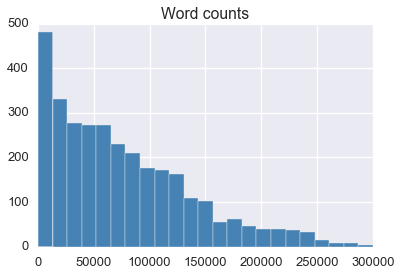

In [189]:
words_fig = plt.hist(list(philo['words']), color=basecolor, bins=np.linspace(0,300000,24))
plt.title('Word counts')

Hmm ... that's a bit worrying. What's with all the short books? Take a closer look ...

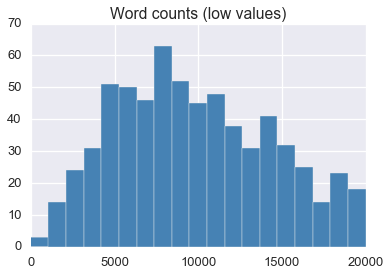

In [190]:
words_fig2 = plt.hist(list(philo['words']), color=basecolor, bins=np.linspace(0,20000,20))
plt.title('Word counts (low values)')

Meh, guess there are just a lot of pamphlets in the dataset. Moving on.

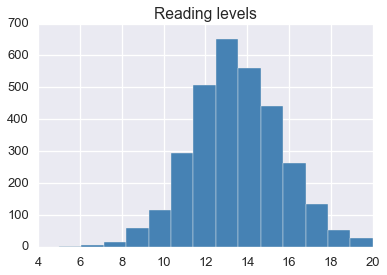

In [287]:
read_fig = plt.hist(list(philo['read']), color=basecolor, bins=np.linspace(5,20,15))
plt.title('Reading levels')

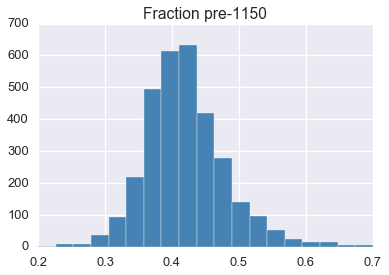

In [192]:
pre_fig = plt.hist(list(philo['pre']), color=basecolor, bins=np.linspace(0.2,0.7,20))
plt.title('Fraction pre-1150')

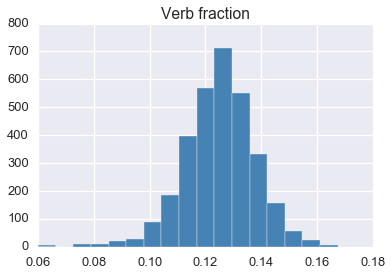

In [193]:
verb_fig = plt.hist(list(philo['verb']), color=basecolor, bins=np.linspace(0.06,0.18,20))
plt.title('Verb fraction')

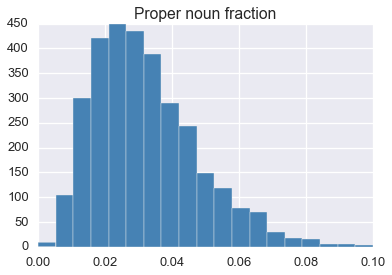

In [194]:
nounp_fig = plt.hist(list(philo['nounp']), color=basecolor, bins=np.linspace(0,0.1,20))
plt.title('Proper noun fraction')

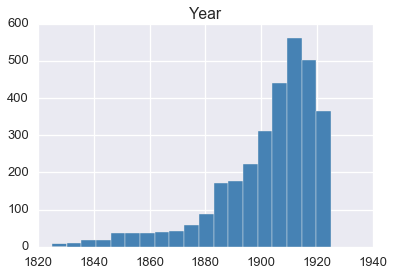

In [290]:
year_fig = plt.hist(list(philo['year']), color=basecolor, bins=np.linspace(1825,1925,20))
plt.title('Year')

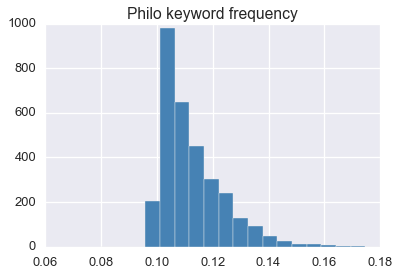

In [294]:
freq_fig = plt.hist(list(philo['freq']), color=basecolor, bins=np.linspace(0.08,0.18,20))
plt.title('Philo keyword frequency')

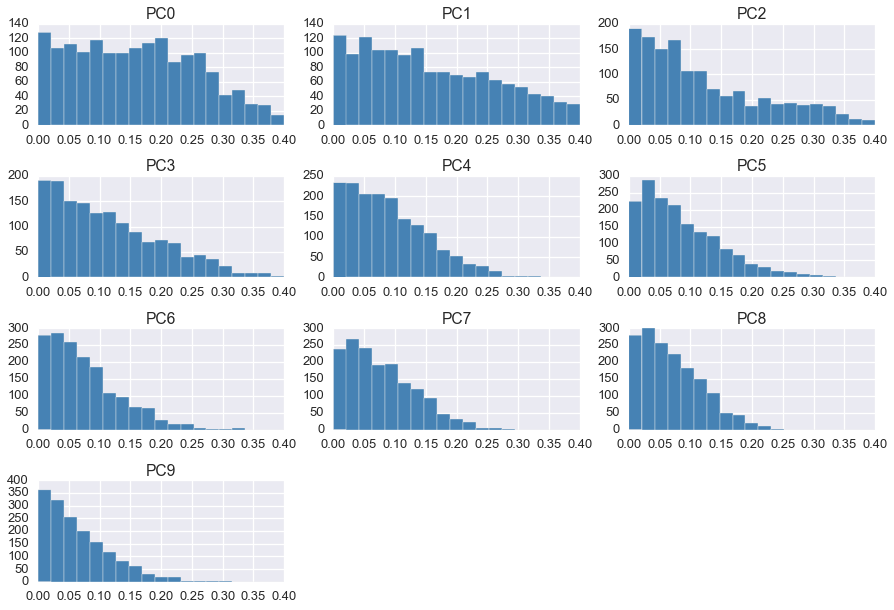

In [195]:
# And the TFIDF PCAs
pca_fig = plt.figure(figsize=(15,10))
for i in range(10):
    component = 'PC'+str(i)
    figno = i+1
    subfig = pca_fig.add_subplot(4,3,figno)
    subfig.hist(list(philo[component]), color=basecolor, bins=np.linspace(0,0.4,20))
    subfig.set_title(component)

OK, all our data is in place, though it's not (yet) normalized. Time to do some clustering and visualization.

## Clustering

We'll try both _k_-means and DBSCAN ...

In [196]:
# Extract data for scikit-learn and normalize
philo_labels = list(philo['label'])
philo_data = philo.drop(['label', 'title', 'auth', 'htid', 'path'], axis=1)
philo_data = philo_data.as_matrix()
scaler = StandardScaler()
philo_data = scaler.fit_transform(philo_data)
print(np.mean(philo_data), np.std(philo_data))
print(philo_data.shape)

4.50188678786e-16 1.0
(3165, 17)


Note that the normalized mean is zero and standard deviation is 1. There are 3165 documents, each having 17 features (10 word-based PCs and 7 form/metadata features).

In [198]:
# k-means
k = 7 # Matches number of human labels
km = KMeans(n_clusters=k)
%time km.fit(philo_data)

CPU times: user 954 ms, sys: 13.1 ms, total: 967 ms
Wall time: 558 ms


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=7, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [200]:
# Examine the labels for k-means
k_labels = km.labels_.tolist()
k_labels = pd.Series(k_labels, index=philo.index, name='k_label')
k_labels.value_counts()

6    940
2    600
0    466
1    451
4    378
3    263
5     67
Name: k_label, dtype: int64

In [233]:
# Same thing for DBSCAN
db = DBSCAN(eps=2.44, min_samples=10)
%time db.fit(philo_data)
d_labels = db.labels_.tolist()
d_labels = pd.Series(d_labels, index=philo.index, name='d_label')
d_labels.value_counts()

CPU times: user 719 ms, sys: 18.5 ms, total: 737 ms
Wall time: 727 ms


-1    1889
 0    1162
 1      58
 4      17
 5      12
 3      12
 6      10
 2       5
Name: d_label, dtype: int64

In [240]:
# Add cluster labels to data frame for plotting
philo['k_label'] = k_labels
philo['d_label'] = d_labels

## Plots

### Human labels

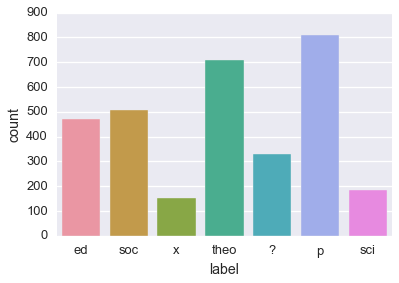

In [241]:
# Human labels
sns.countplot(x='label', data=philo)

### k-means

**NB.** Labels aren't correlated with human labels, so this IS NOT a plot of performance vs. humans. Don't read anything into the colors or ording of clusters.

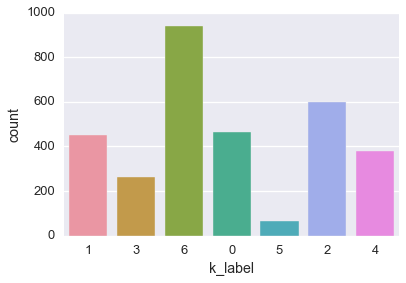

In [242]:
# k-means
sns.countplot(x='k_label', data=philo)

### DBSCAN

Ditto re: lack of correlation here. Note that cluster `-1` means "no cluster" or "outlier."

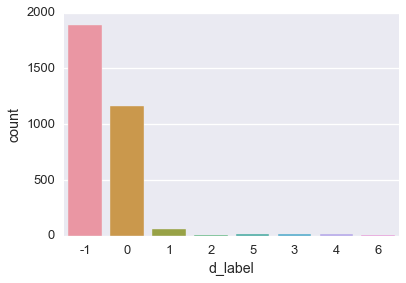

In [244]:
sns.countplot(x='d_label', data=philo)

### Plot in PCA space to see the clusters

In [248]:
# Reduce philo_data to two dimensions for plotting
dim = 2
pca_plot = PCA(n_components=dim)

%time philo_data_plot = pca_plot.fit_transform(philo_data)

CPU times: user 3.62 ms, sys: 1.22 ms, total: 4.84 ms
Wall time: 3.96 ms


In [256]:
# Add the PCs to data frame for easier plotting
philo['P1'] = philo_data_plot[:,0]
philo['P2'] = philo_data_plot[:,1]

### Human labels

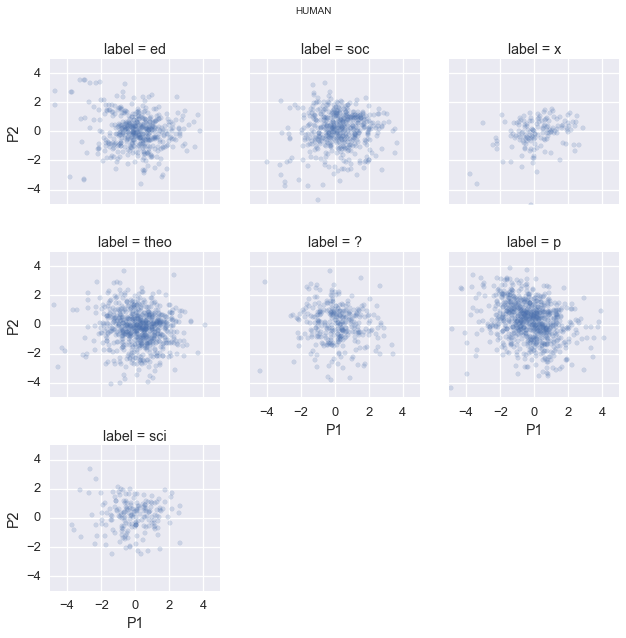

In [280]:
human_plot = sns.FacetGrid(philo, col='label', col_wrap = 3)
human_plot.map(plt.scatter, 'P1', 'P2', alpha=0.2)
human_plot.set(xlim=(-5,5), ylim=(-5,5))
plt.subplots_adjust(top=0.9)
human_plot.fig.suptitle('HUMAN')

### _k_-Means labels

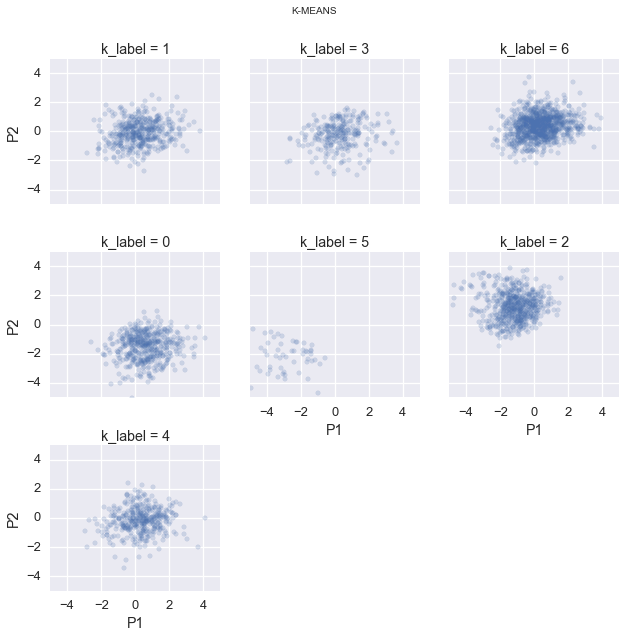

In [282]:
k_plot = sns.FacetGrid(philo, col='k_label', col_wrap = 3)
k_plot.map(plt.scatter, 'P1', 'P2', alpha=0.2)
k_plot.set(xlim=(-5,5), ylim=(-5,5))
plt.subplots_adjust(top=0.9)
k_plot.fig.suptitle('K-MEANS')

### DBSCAN labels

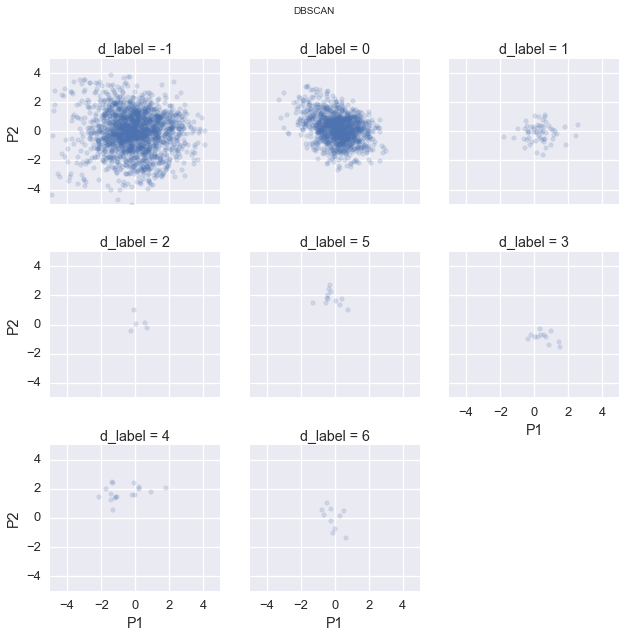

In [286]:
# DBSCAN
d_plot = sns.FacetGrid(philo, col='d_label', col_wrap = 3)
d_plot.map(plt.scatter, 'P1', 'P2', alpha=0.2)
d_plot.set(xlim=(-5,5), ylim=(-5,5))
plt.subplots_adjust(top=0.9)
d_plot.fig.suptitle('DBSCAN')

## To do

Much left to do here, especially in terms of analysis:

* Perform grid search on DBSCAN to find best parameters. Currently non-optimal; see few large clusters and tendency to mark many as noise. Dimensionality may be too high overall.
* Correlate human labels with machine labels. Maybe just by majority vote vs. human labels.
* And then spend some serious time figuring out what, if anything, this tells us about the subgenres of philosophy.
* Part of the analytical work will involve examining the PCA loadings to see what's driving texts in certain directions.
* Extend the same analsysis to literary criticism.